# Analyzing Simulation Results

Note that:
- g1 - group 1

- g2 - group 2

## 1. Functions to Create Visualizations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import ast
import os
import dataframe_image as dfi

In [2]:
# set default font sizes for graphing later on
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Inputs (Changeable but limited)
parameter_num = 50 # either 20 or 50, depending on what parameters you want simulation to have

# Inputs (not changeable)
parameter_title = 'parameters_w_' + str(parameter_num)
sheet_names = ["L_0", "C_1", "L_3", "Time_Exec"]

# folder names (changeable)
image_title = 'simulation_results'
graphs = 'graphs'
t_comparison = 't_comparison'

In [4]:
# for reading excel sheet
parameter_excel_title = parameter_title + '.xlsx'
xls = pd.ExcelFile(parameter_excel_title)
sheet_names_og = xls.sheet_names

# go into folder
og_directory = os.getcwd()
os.chdir(parameter_title)
folder_directory = os.getcwd()

In [5]:
def analyze_simulation_results(parameter_sheet_name_index, level, show = False):
    os.chdir(og_directory)
    df = pd.read_excel(xls, sheet_name=sheet_names_og[parameter_sheet_name_index])
    os.chdir(parameter_title)
    os.chdir(sheet_names_og[parameter_sheet_name_index])
    all_file_names = [i + '.xlsx' for i in df['name_file'].tolist()] # MANUAL INPUT
    all_file_names
    i = 0
    tracker = 0
    average_parity_t = np.zeros(len(all_file_names))
    percentage_parity_reached = np.zeros(len(all_file_names))
    counter = 0
    overall_g1_time_avg = np.zeros(len(all_file_names))
    overall_g2_time_avg = np.zeros(len(all_file_names))
    for file_name in all_file_names:
        test_df = pd.read_excel(file_name, level)
        test_df = test_df.iloc[: , 1:]
        test_df['mean'] = test_df.mean(axis=1)
        
        # GET HOW MUCH FASTER G2 THAN G1 REACH EXEC LEVEL
        time_df = pd.read_excel(file_name, sheet_names[3])
        g1_time_df = time_df[time_df['group'] == 0]
        g2_time_df = time_df[time_df['group'] == 1]
        overall_g1_time_avg[i] = pd.Series(g1_time_df['time_end'].mean())
        overall_g2_time_avg[i] = pd.Series(g2_time_df['time_end'].mean())  
        if i == 0:
            new_df = test_df['mean']
            i+=1
        else:
            new_df = pd.concat([new_df, test_df['mean']], axis=1)
            i+=1
        if show:
            plt.figure()
            plt.plot(test_df)
            plt.title(file_name)
        
        # GET WHERE WE REACH PARITY
        t_values = np.zeros(test_df.shape[1])
        counter = 0
        for j in range(test_df.shape[1]):
            reaches_parity = np.where(test_df.iloc[:,j] >= 0.48, True, False)
            indices_parity = np.where(reaches_parity == True)
            if len(indices_parity[0]) > 0:
                t_values[j] = np.min(indices_parity[0])
                # may be counting it wrong
                counter = counter + 1
        average_parity_t[tracker] = np.sum(t_values) / counter
        percentage_parity_reached[tracker] = counter / test_df.shape[1]
        tracker+=1
            
        
    if show:
        plt.show()
    
    # for graph of simulations
    new_df.columns = df['name_file'].tolist()
    
    # for when we reach parity
    average_parity_t = pd.Series(average_parity_t)
    percentage_parity_reached = pd.Series(percentage_parity_reached)
    parity_reached_df = pd.concat([average_parity_t, percentage_parity_reached], axis=1)
    parity_reached_df.columns = ['avg_parity_t', 'Percent_parity_reached']
    
    overall_g1_time_avg = pd.Series(overall_g1_time_avg)
    overall_g2_time_avg = pd.Series(overall_g2_time_avg)
    
    overall_time_dict = {'g1_time': overall_g1_time_avg, 'g2_time': overall_g2_time_avg}
    overall_time_df = pd.DataFrame(overall_time_dict)
    
    
    os.chdir(og_directory) # return back to original directory
    # for tracking how fast it takes to reach exec level
    # DIFFERENCE IN ASSERTIVENESS
    return new_df, df, parity_reached_df, overall_time_df

In [6]:
# PARAMETER DIFFERENCE INDEX
# 0: a
# 1: alpha
# 2: beta
# 3: for constant prefilled (don't use)
# 4: for vary prefilled (don't use)
def graph_simulation_results1(new_df, graph_name, parameter_difference_index, show_parity = False, legend_x=1, legend_y=1, font_size = (10,10,10), ylim = (.20,.55)):
    nrows = new_df[1].shape[0]
    parameter_labels = [""] * nrows
    # setting values
    if parameter_difference_index == 0:
        parameter_df = new_df[1].iloc[:,2:4]
        index = 0
        parameter = "a"
    elif parameter_difference_index == 1:
        parameter_df = new_df[1].iloc[:,2:4]
        index = 1
        parameter = "\\alpha"
    elif parameter_difference_index == 2:
        parameter_df = new_df[1].iloc[:,4]
    else:
        parameter_df = new_df[1].iloc[:,8]
        
    if parameter_difference_index in {0, 1}:
        first_string = "$\mu_" + parameter + "(1)="
        second_string = ",\mu_" + parameter + "(2)="
        for i in range(nrows):
            first_value = parameter_df.iloc[:,0][i].strip("[").strip("]").split(",")[index]
            second_value = parameter_df.iloc[:,1][i].strip("[").strip("]").split(",")[index]
            first_string = r"$\mu_" + parameter + "(1)=" + first_value
            second_string = ",\mu_" + parameter + "(2)=" + second_value + "$"
            parameter_labels[i] = first_string + second_string
    elif parameter_difference_index == 2:
        for i in range(nrows):
            first_string = r"$\beta="
            first_value = str(parameter_df.iloc[i]) + "$"
            parameter_labels[i] = first_string + first_value
    elif parameter_difference_index == 3:
        for i in range(nrows):
            first_string = r"Number at $L_n$, $C_n$: "
            temp_value = ast.literal_eval(parameter_df.iloc[i])
#             print(temp_value[0][0])
#             print(temp_value[0][1])
#             print(temp_value[0][2])
#             print(temp_value[1][0])
            first_value = str(temp_value[0][1])
            parameter_labels[i] = first_string + first_value
    elif parameter_difference_index == 4:
        for i in range(nrows):
            first_string = r"Number at $L_1$: "
            temp_value = ast.literal_eval(parameter_df.iloc[i])
#             print(temp_value[0][0])
#             print(temp_value[0][1])
#             print(temp_value[0][2])
#             print(temp_value[1][0])
            first_value = str(temp_value[0][1])
            parameter_labels[i] = first_string + first_value
        
    
    parameter_labels_series = pd.Series(parameter_labels)
    parity_reached_df = pd.concat([parameter_labels_series,new_df[2]], axis=1)
    if show_parity:
        display(parity_reached_df)
        
    plt.figure(10)
    # ADDED
    num_cols = len(new_df[0].axes[1])
    iterations = new_df[0].index
    linestyle_tuple = [(0, ()), (0, (1, 1)), (0, (5, 5)), (0, (3, 5, 1, 5)), (5, (10, 3)), (0, (3, 1, 1, 1))]
    for i in range(num_cols):
        plt.plot(iterations, new_df[0].iloc[:, i], linestyle=linestyle_tuple[i])
    # ADDED
    plt.legend(labels = parameter_labels,  bbox_to_anchor=(legend_x, legend_y), fontsize = font_size[0])
    plt.xlabel(r"Time $t$", fontsize = font_size[1])
    plt.ylabel('Group-1 Proportion at Top Level', fontsize = font_size[1])
    plt.ylim(ylim[0], ylim[1])
    plt.xticks(fontsize = font_size[2])
    plt.yticks(fontsize = font_size[2])
    plt.title(graph_name)

In [7]:
# create folders to store information
def store_results(plot_name, df):
    os.chdir(og_directory)
    os.chdir(parameter_title)
    if os.path.isdir(image_title):
        os.chdir(image_title)
    else:
        os.makedirs(image_title)
        os.chdir(image_title)
    image_directory = os.getcwd()
    
    if os.path.isdir(graphs):
        os.chdir(graphs)
    else:
        os.makedirs(graphs)
        os.chdir(graphs)
        
    plt.savefig(plot_name,  bbox_inches = 'tight')
    
    os.chdir(image_directory)
    
    if os.path.isdir(t_comparison):
        os.chdir(t_comparison)
    else:
        os.makedirs(t_comparison)
        os.chdir(t_comparison)
    dfi.export(df, plot_name)
    
    os.chdir(og_directory)
    

## 2. Visualizations and Saving Information

In [11]:
file_names = sheet_names_og
print(file_names)

['a', ' alpha', 'a_alpha', 'beta', 'a_diff_constant_prefilled', 'alpha_diff_constant_prefilled', 'a_alpha_diff_constant_prefilled', 'beta_diff_constant_prefilled', 'a_diff_var_prefilled', 'alpha_diff_var_prefilled', 'a_alpha_diff_var_prefilled', 'beta_diff_var_prefilled']


# Input
Depending on which visualization you want, you need to change the index. Run the code below to know:

In [12]:
for i in range(len(file_names)):
    output = str(i) + ": " + file_names[i]
    print(output)

0: a
1:  alpha
2: a_alpha
3: beta
4: a_diff_constant_prefilled
5: alpha_diff_constant_prefilled
6: a_alpha_diff_constant_prefilled
7: beta_diff_constant_prefilled
8: a_diff_var_prefilled
9: alpha_diff_var_prefilled
10: a_alpha_diff_var_prefilled
11: beta_diff_var_prefilled


In [17]:
# IMPORTANT: CHANGE THE INPUT FOR DESIRED VISUALIZATION

# 0-11 (shows visualization accordingly)
index = 3

# 0: a
# 1: alpha
# 2: beta
# 3: if title contains constant_prefilled (don't use - used for paper)
# 4: if title contains var_prefilled (don't use - used for paper)
parameter_type = 1 # changes the legend according to which parameter you want

# if desired, change change parameter values of plot
plot_name = ""
legend_x = 1 # location of legend
legend_y = 1 # location of legend
y_lim = (.2, .55) # y limit values
# font size is already input

This may take a couple minutes to run.

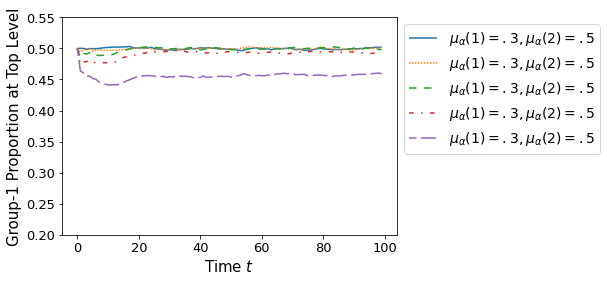

In [18]:
df = analyze_simulation_results(index, sheet_names[2])
# graph_simulation_results1(df, plot_name, parameter_type) # should one want to use default values
graph_simulation_results1(df, plot_name, parameter_type, False, legend_x, legend_y, font_size=(14,15,13), ylim = y_lim)
final_file_name = file_names[index] + "_results"
store_results(final_file_name, df[3])